In [226]:
from nutils import*
from nutils.pointsseq import PointsSequence
import numpy as np
from matplotlib import pyplot as plt
import os

In [244]:
# number of elements
Nb = 6
Na = 6
# domain lengths
Lb = 1
La = 1
# basis degree
basis_degree = 2
# blood material props
E_b = 1 # MPa 
# artery material properties
E_a = 10 # MPa 
# blood pressure
pi = .012 # Mpa
# bias
epsilon = 0

In [245]:
# build mesh
rb = Lb
ra = Lb + La
omega = function.Namespace()
xb = np.linspace(0, rb, Nb + 1)
xa = np.linspace(rb, ra, Na + 1)
x = np.concatenate([xb, xa[1::]])
omega_topo, omega.x = mesh.rectilinear([x])

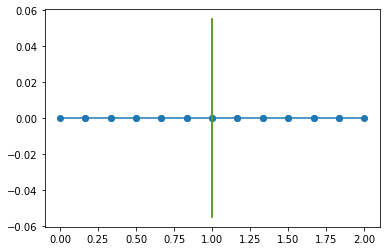

In [246]:
# Plot Mesh
vert_vals = omega_topo.sample('bezier', 2).eval(omega.x)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(vert_vals,[0]*len(vert_vals),'o-')
ylims = ax.get_ylim()
ax.plot([rb,rb],ylims)
ax.plot([rb - epsilon,rb - epsilon],ylims)
plt.show()

In [247]:
# Build basis
N = Nb + Na
knotvals = [x]
knotmults = [np.ones(N+1,dtype=int)]
knotmults[0][0] = basis_degree
knotmults[0][-1] = basis_degree
knotmults[0][Nb] = basis_degree
omega.basis = omega_topo.basis('spline', degree = basis_degree, knotvalues = knotvals, knotmultiplicities=knotmults)

In [248]:
#omega.basis = omega_topo.basis('spline', degree = basis_degree)

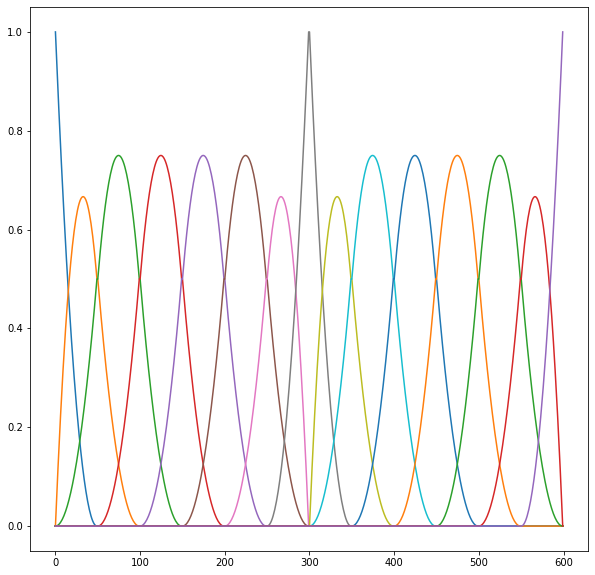

In [249]:
# plot basis
nsamples_basis_plot = 50
basis_vals = omega_topo.sample('bezier',nsamples_basis_plot).eval(omega.basis)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(basis_vals)
plt.show()

In [253]:
mat_degree = basis_degree

# build material properties functions
class YoungsModulus(function.Pointwise):
    @staticmethod
    def evalf(x):
        val0 = E_b * (1.0 - np.heaviside(x**2 - rb**2 + epsilon , 1))
        val1 = E_a * np.heaviside(x**2 - rb**2 + epsilon, 1)
        return val0 + val1
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)

omega.E = YoungsModulus(omega.x[0])

In [251]:
omega.E = omega_topo.projection(omega.E, onto=omega.basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3))

project > constrained 15/15 dofs


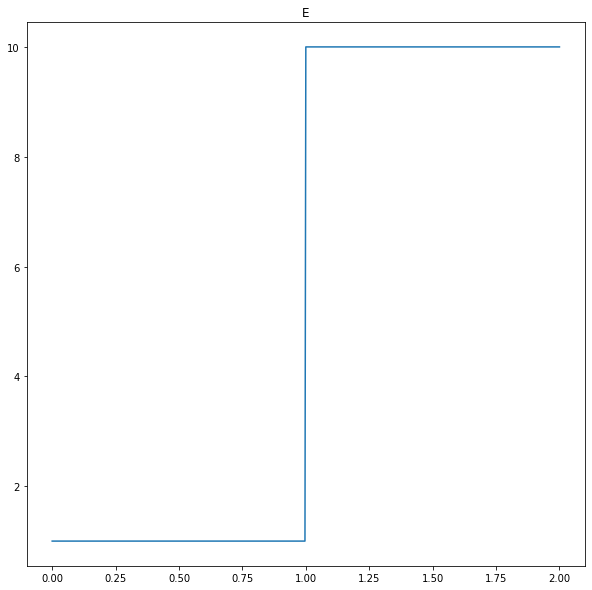

In [254]:
# plot material properties functions
nsamples_matprops_plot = 50
sample_matprops = omega_topo.sample('bezier',nsamples_matprops_plot)
x_vals = sample_matprops.eval(omega.x)
E_vals = sample_matprops.eval(omega.E)
fig = plt.figure(figsize=(10, 10))
ax_E = fig.add_subplot(1,1,1)
ax_E.set_title('E')
ax_E.plot(x_vals, E_vals)
plt.show()

In [255]:
# Extract the blood subset topology
blood = function.Namespace()
blood_topo = topology.SubsetTopology(omega_topo, [omega_topo.references[i] if i < Nb else omega_topo.references[i].empty for i in range(N)])
blood_topo_loaded_boundary = topology.SubsetTopology(blood_topo.boundary, [blood_topo.boundary.references[0], blood_topo.boundary.references[1].empty])

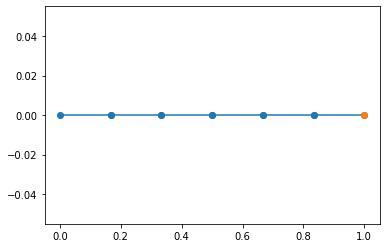

In [256]:
# Plot Blood Domain
xb_vals = blood_topo.sample('bezier', 2).eval(omega.x)
plt.plot(xb_vals,[0]*len(xb_vals),'o-')
xb_loaded_boundary_vals = blood_topo_loaded_boundary.sample('bezier',2).eval(omega.x)
plt.plot(xb_loaded_boundary_vals,[0]*len(xb_loaded_boundary_vals),'o-')

In [257]:
fake_topo, fake_geom = mesh.rectilinear([xb])
fake_basis = fake_topo.basis('spline', degree=basis_degree)

In [258]:
# Solve the Blood problem
blood = function.Namespace()
blood.x = omega.x
blood.E = omega.E
blood_knotvals = [xb]
blood_knotmults = [np.ones(Nb+1,dtype=int)]
blood_knotmults[0][0] = basis_degree
blood_knotmults[0][-1] = basis_degree
#blood.ubasis = blood_topo.basis('spline', degree = basis_degree, knotvalues = blood_knotvals, knotmultiplicities=blood_knotmults)
blood.ubasis = fake_basis
blood.u = 'ubasis_n ?alpha_n'
blood.strain = 'u_,0'
blood.stress = 'E strain'
blood.pi = pi
Kblood = blood_topo.integral('ubasis_n,0 stress d:x' @ blood, degree = np.max([1, 2 * (basis_degree-1) + mat_degree]))
Fblood = blood_topo_loaded_boundary.integral('pi n_0 ubasis_n d:x' @ blood, degree=basis_degree)
sqr_blood = blood_topo.boundary['left'].integral('u^2 d:x' @ blood, degree = 2 * basis_degree)
cons_blood = solver.optimize('alpha', sqr_blood, droptol=1e-11)
alpha = solver.solve_linear('alpha', residual=Kblood-Fblood, constrain=cons_blood)

optimize > constrained 1/8 dofs
optimize > optimum value 0.00e+00
solve > solving 7 dof system to machine precision using arnoldi solver
solve > solver returned with residual 8e-18


In [260]:
# Sample Blood Problem Solution
nsamples = 100
blood_sample = blood_topo.sample('gauss',nsamples)
blood_basis_vals = blood_sample.eval(blood.ubasis)
u_vals = blood_sample.eval(blood.u, alpha=alpha)
x_vals = blood_sample.eval(blood.x)
stress_vals = blood_sample.eval(blood.stress, alpha=alpha)
strain_vals = blood_sample.eval(blood.strain, alpha=alpha)

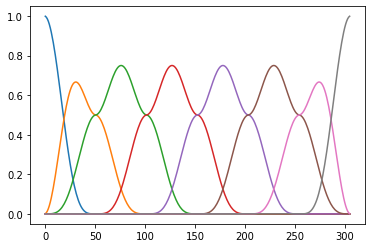

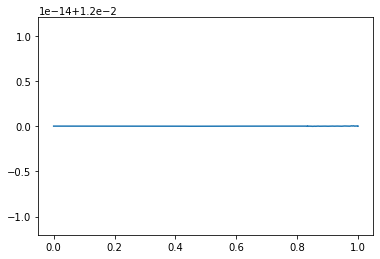

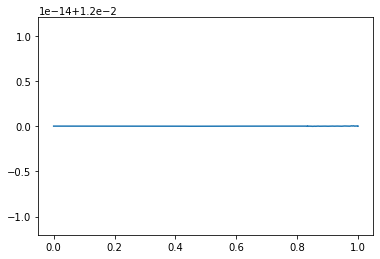

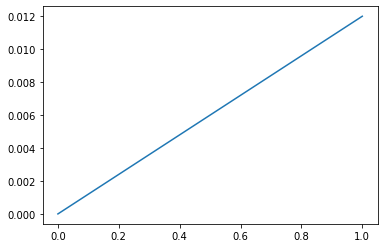

In [261]:
# Plot Blood Problem Solution
plt.plot(blood_basis_vals)
plt.show()
plt.plot(x_vals, stress_vals)
plt.show()
plt.plot(x_vals, strain_vals)
plt.show()
plt.plot(x_vals, u_vals)
plt.show()

In [262]:
# Solve Full Problem
omega.ubasis = omega.basis
omega.u = 'ubasis_n ?lhs_n'
omega.strain = 'u_,0'
omega.stress = 'E strain'
K = omega_topo.integral('ubasis_n,0 stress d:x' @ omega, degree= 2 * (basis_degree-1) + mat_degree)
#K -= blood_topo.integral('ubasis_n,0 stress d:x' @ omega, degree= 2 * (basis_degree-1) + mat_degree)

# Force Vector
blood.fullbasis = omega.ubasis
F = blood_topo.integral('fullbasis_n,0 stress d:x' @ blood(alpha=alpha), degree=np.max([1, 2 * (basis_degree-1) + mat_degree]))


# Constrain Omega
sqr  = omega_topo.boundary['right'].integral('u^2 d:x' @ omega, degree=2 * basis_degree)
sqr += omega_topo.boundary['left'].integral('u^2 d:x' @ omega, degree=2 * basis_degree)
cons = solver.optimize('lhs', sqr, droptol=1e-11)
lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

optimize > constrained 2/15 dofs
optimize > optimum value 0.00e+00
solve > solving 13 dof system to machine precision using arnoldi solver
solve > solver returned with residual 6e-18


In [265]:
# Sample Full Problem Solution
nsamples = 10
omega_sample = omega_topo.sample('gauss',nsamples)
omega_basis_vals = omega_sample.eval(omega.ubasis)
u_vals = omega_sample.eval(omega.u, lhs=lhs)
x_vals = omega_sample.eval(omega.x)
E_vals = omega_sample.eval(omega.E)
stress_vals = omega_sample.eval(omega.stress, lhs=lhs)
strain_vals = omega_sample.eval(omega.strain, lhs=lhs)

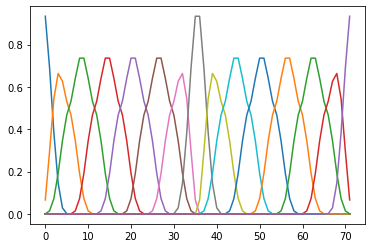

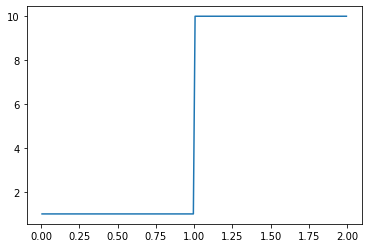

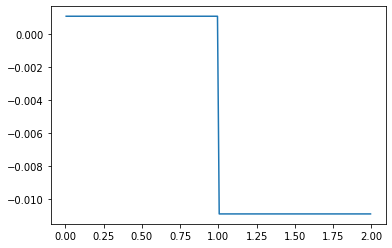

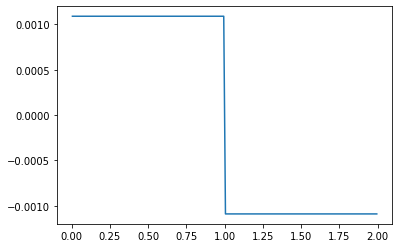

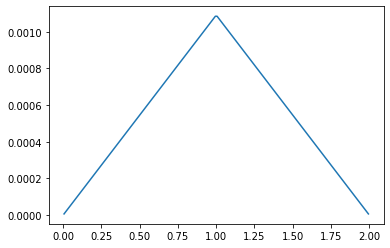

In [266]:
# Plot Blood Problem Solution
plt.plot(omega_basis_vals)
plt.show()
plt.plot(x_vals, E_vals)
plt.show()
plt.plot(x_vals, stress_vals)
plt.show()
plt.plot(x_vals, strain_vals)
plt.show()
plt.plot(x_vals, u_vals)
plt.show()

In [63]:
print(alpha)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [62]:
print(Fblood.eval())

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.006 0.006]


In [175]:
# Solve the Blood problem
omega.basis = omega_topo.basis('spline',degree=basis_degree)
omega.u = 'basis_n ?beta_n'
omega.strain = 'u_,0'
omega.stress = 'strain'
omega.pi = pi
Kblood = omega_topo.integral('basis_n,0 stress d:x' @ omega, degree= 2 * (basis_degree-1) + mat_degree)
Fblood = omega_topo.boundary["right"].integral('- pi n_0 basis_n d:x' @ omega, degree=basis_degree)
sqr_blood = omega_topo.boundary['left'].integral('u^2 d:x' @ omega, degree = 2 * basis_degree)
cons_blood = solver.optimize('beta', sqr_blood, droptol=1e-11)
beta = solver.solve_linear('beta', residual=Kblood+Fblood, constrain=cons_blood)

optimize > constrained 1/14 dofs
optimize > optimum value 0.00e+00
solve > solving 13 dof system to machine precision using arnoldi solver
solve > solver returned with residual 3e-17


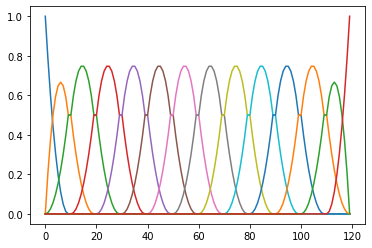

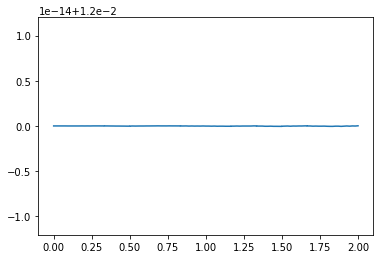

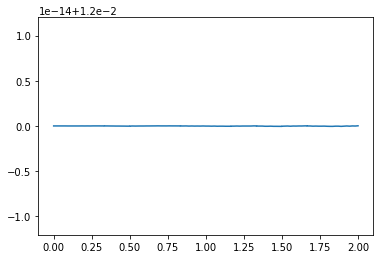

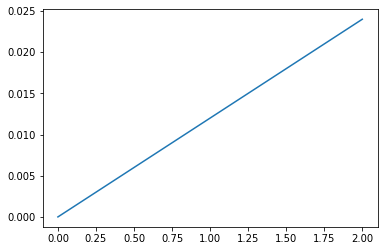

In [176]:
# Sample Full Problem Solution
nsamples = 10
omega_sample = omega_topo.sample('bezier',nsamples)
omega_basis_vals = omega_sample.eval(omega.basis)
u_vals = omega_sample.eval(omega.u, beta=beta)
x_vals = omega_sample.eval(omega.x)
E_vals = omega_sample.eval(omega.E)
stress_vals = omega_sample.eval(omega.stress, beta=beta)
strain_vals = omega_sample.eval(omega.strain, beta=beta)

# Plot Blood Problem Solution
plt.plot(omega_basis_vals)
plt.show()
plt.plot(x_vals, stress_vals)
plt.show()
plt.plot(x_vals, strain_vals)
plt.show()
plt.plot(x_vals, u_vals)
plt.show()

(15,)
[-6.00000000e+00  8.88178420e-16  1.33226763e-15 -8.88178420e-16
 -1.33226763e-15  1.77635684e-15  4.44089210e-15 -8.88178420e-16
 -2.66453526e-15  8.88178420e-16  8.88178420e-16  4.44089210e-16
  4.44089210e-15  8.88178420e-16  6.00000000e+00]


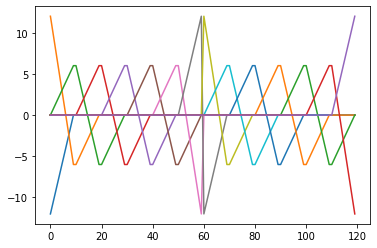

In [166]:
omega.f_n = 'basis_n,0'
nsamples = 10
sample = omega_topo.sample('bezier',nsamples)
vals = sample.eval(omega.f)
plt.plot(vals)
print(omega.basis.shape)

I = omega_topo.integral('basis_n,0' @ omega, degree=3)
print(I.eval())

In [19]:
print(x)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
